In [4]:
!pip install pandas
!pip install matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# Redefine the effective potential function V
def V(x, y, mu):
    r1 = np.sqrt((x + mu)**2 + y**2)
    r2 = np.sqrt((x - 1 + mu)**2 + y**2)
    return -(0.5*(x**2 + y**2) + (1 - mu)/r1 + mu/r2)
def grad_V(x, y, mu):
    r1 = np.sqrt((x + mu)**2 + y**2)
    r2 = np.sqrt((x - 1 + mu)**2 + y**2)
    dVdx = -(x - ((1 - mu) * (x + mu) / r1**3) - (mu * (x - 1 + mu) / r2**3))
    dVdy = -(y - (1 - mu) * y / r1**3 - mu * y / r2**3)
    return np.array([dVdx, dVdy])

def initial_velocities(x, y, E, mu):
    Vxy = V(x, y, mu)
    kinetic_energy = E - Vxy
    if kinetic_energy <= 0:
        return np.array([0, 0]), False  # No real velocities possible, point is in forbidden region
    v_mag = np.sqrt(2 * kinetic_energy)
    # Velocity is perpendicular to gradient of V
    # Ensure the velocity is perpendicular to the radial direction and points clockwise
    vel_dir = np.array([y, -x])  # Correct direction for clockwise
    vel_dir /= np.linalg.norm(vel_dir)
    return v_mag * vel_dir, True

def equations_of_motion(t, state, mu):
    x, y, vx, vy = state
    ax = 2*vy - grad_V(x, y, mu)[0]
    ay = -2*vx - grad_V(x, y, mu)[1]
    return [vx, vy, ax, ay]

grid_size = 124  # Size of the grid for initial positions
x_vals = np.linspace(-2, 2, grid_size)
y_vals = np.linspace(-2, 2, grid_size)

#Initial conditions
E = -1.7
mu = 1/3
# Storage for initial conditions that are not in forbidden regions
initial_conditions_final = []

for x in x_vals:
    for y in y_vals:
        velocity, is_allowed = initial_velocities(x, y, E, mu)
        if is_allowed:
            initial_conditions_final.append((x, y, velocity[0], velocity[1]))

In [7]:
print(len(initial_conditions_final))

11604


In [8]:
# A bunch of initial conditions to test

filtered_conditions_green = [
    condition for condition in initial_conditions_final
    if -0.51<= condition[0] <= -0.49 and -0.1 <= condition[1] <= 0.1
]
# Let's do orange, coordinates is (0.8,0) and orange is orbit type 2b (stable orbit)
filtered_conditions_orange = [
    condition for condition in initial_conditions_final
    if 0.84<= condition[0] <= 0.85 and -0.1 <= condition[1] <= 0.1
]
filtered_conditions_crash_a = [
    condition for condition in initial_conditions_final
    if 0 <= condition[0] <= 0.01 and 0 <= condition[1] <= 0.01
]
# the body will collide with the second body in this scenario
filtered_conditions_crash_b = [
    condition for condition in initial_conditions_final
    if 0.66 <= condition[0] <= 0.67  and -0.01 <= condition[1] <= 0.01
]

def bulirsch_stoer_crash(equations_of_motion, initial_state, tpoints, H, delta, mu):
    R_crash = 0.01  # Crash radius
    xpoints = []
    ypoints = []
    x_dotpoints = []
    y_dotpoints = []
    safety = 0.9  # Safety factor for adaptive step sizing
    min_h_factor = 0.2  # Minimum factor to reduce H by
    max_h_factor = 2.0  # Maximum factor to increase H by
    min_step_size = 1e-6  # Minimum allowable step size to prevent infinite loop
    max_iters = 100000  # Maximum number of iterations to prevent infinite loop


    state = np.array(initial_state)  # Convert initial state to numpy array for vectorized operations
    t = tpoints[0]  # Starting time
    iterations = 0  # Initialize iterations counter

    for t_next in tpoints[1:]:
        while t < t_next and iterations < max_iters:
            # Adapt step size
            H = min(H, t_next - t)
            if H < min_step_size:
                print("Minimum step size reached. Stopping integration.")
                return xpoints, ypoints, x_dotpoints, y_dotpoints

            n = 1
            converged = False
            while not converged and iterations < max_iters:
                iterations += 1

                # Midpoint method steps
                r1 = state + 0.5 * H * np.array(equations_of_motion(t, state, mu))
                r2 = state + H * np.array(equations_of_motion(t + 0.5 * H, r1, mu))
                R1 = np.empty((1, 4), float)
                R1[0] = 0.5 * (r1 + r2 + 0.5 * H * np.array(equations_of_motion(t + H, r2, mu)))

                error = 2 * H * delta
                while error > H * delta and iterations < max_iters:
                    iterations += 1
                    n += 1
                    h = H / n
                    r1 = state + 0.5 * h * np.array(equations_of_motion(t, state, mu))
                    r2 = state + h * np.array(equations_of_motion(t + 0.5 * h, r1, mu))
                    for i in range(n - 1):
                        r1 += h * np.array(equations_of_motion(t + (i + 1) * h, r2, mu))
                        r2 += h * np.array(equations_of_motion(t + (i + 1.5) * h, r1, mu))

                    R2 = R1
                    R1 = np.empty((n, 4), float)
                    R1[0] = 0.5 * (r1 + r2 + 0.5 * h * np.array(equations_of_motion(t + h, r2, mu)))
                    for m in range(1, n):
                        epsilon = (R1[m - 1] - R2[m - 1]) / ((n / (n - 1))**(2 * m) - 1)
                        R1[m] = R1[m - 1] + epsilon
                    error = np.linalg.norm(epsilon)

                # Check for convergence and adapt step size
                if error < H * delta:
                    converged = True
                    state = R1[n - 1]
                    t += H
                else:
                    # Reduce step size if the method didn't converge
                    H *= max(safety * (delta / error)**0.25, min_h_factor)
                    if H < min_step_size:
                        return xpoints, ypoints, x_dotpoints, y_dotpoints

            xpoints.append(state[0])
            ypoints.append(state[1])
            x_dotpoints.append(state[2])
            y_dotpoints.append(state[3])
            d1 = np.sqrt((state[0] + mu)**2 + state[1]**2)  # Distance to the first primary
            d2 = np.sqrt((state[0] - 1 + mu)**2 + state[1]**2)  # Distance to the second primary
            # Crash detection
            if d1 < R_crash or d2 < R_crash:
                print("Crash detected. Stopping integration.")
                return xpoints, ypoints, x_dotpoints,y_dotpoints  # Stop the loop if a crash is detected

            # Adjust step size for the next iteration
            if error > 0 and iterations < max_iters:
                H *= min(safety * (delta / error)**0.2, max_h_factor)

    if iterations >= max_iters:
        print("Maximum number of iterations reached. Stopping integration.")

    return xpoints, ypoints, x_dotpoints, y_dotpoints

def numerical_integration_plot(initial_state, mu, t_span, dt,plot_visible=False):
    # Define time points for all integration methods
    tpoints = np.arange(t_span[0], t_span[1], dt)

    # Bulirsch-Stoer Integration
    H = dt  # Use the same dt as the step size for integration
    delta = 1e-5  # Accuracy parameter
    xpoints, ypoints, x_dot_points,y_dot_points= bulirsch_stoer_crash(equations_of_motion, initial_state, tpoints, H, delta, mu)

    if (plot_visible):
        fig, ax = plt.subplots(figsize=(14, 12))


        # Bulirsch-Stoer plot
        ax.plot(xpoints, ypoints, label='Bulirsch-Stoer')
        ax.scatter([-mu], [0], color='blue', zorder=5, label='Primary 1')  # Primary 1
        ax.scatter([1-mu], [0], color='orange', zorder=5, label='Primary 2')  # Primary 2
        ax.scatter([initial_state[0]], [initial_state[1]], color='red', zorder=5, label='Body')  # Initial position
        ax.set_title('Bulirsch-Stoer Integration')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.grid(True)
        ax.legend()


        plt.tight_layout()
        plt.show()
    #list(zip(xpoints, ypoints,x_dot_points,y_dot_points))
    return xpoints, ypoints,x_dot_points,y_dot_points



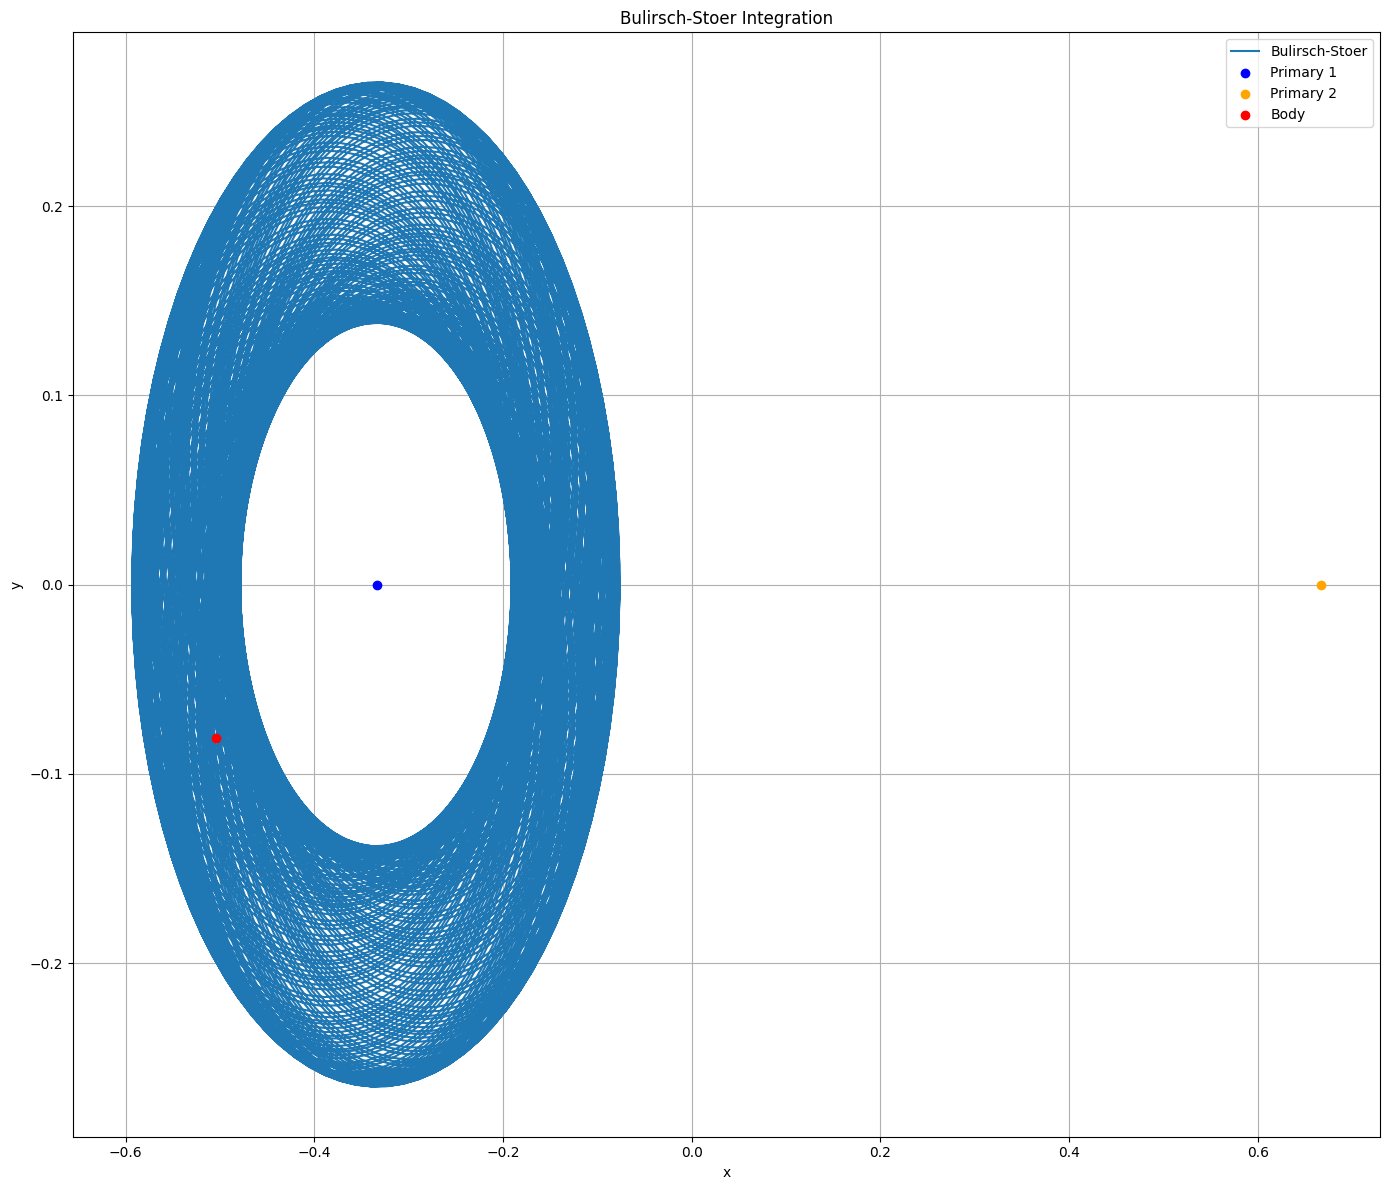

In [9]:
green_orbit = numerical_integration_plot(filtered_conditions_green[0], mu, [0, 100], 0.01, True)
#crash_a_orbit = numerical_integration_plot(filtered_conditions_crash_a[0], mu, [0, 100], 0.01, True)
#crash_b_orbit = numerical_integration_plot(filtered_conditions_crash_b[0], mu, [0, 100], 0.01, True)
#escape_orbit = numerical_integration_plot(initial_conditions_final[0], mu, [0, 100], 0.01, True)


In [10]:
print(green_orbit[0])
print(green_orbit[1])
print(green_orbit[2])
print(green_orbit[3])

[-0.5063628813527251, -0.50637614510539, -0.5038982868626551, -0.4987357660111522, -0.4907227292734328, -0.4797408502129545, -0.46574414529224023, -0.4487869548595459, -0.4290508124156141, -0.40686338604255917, -0.38270121700945803, -0.3571698181821138, -0.33096040643793884, -0.3047905058677788, -0.27934172195015744, -0.25520853014618955, -0.23286684411681832, -0.2126637887388819, -0.19482440289113237, -0.17946857333070287, -0.16663209017329284, -0.15628748061651507, -0.14836226973701333, -0.1427537867893568, -0.13934052420275522, -0.13799048478074707, -0.13856709140431747, -0.14093321976493522, -0.14495383593966138, -0.1504976249990077, -0.1574379069401557, -0.16565306054048778, -0.1750266157144963, -0.18544712912703104, -0.196807923695383, -0.20900674768268893, -0.22194539114071843, -0.23552928470849901, -0.24966709681805152, -0.2642703391424677, -0.2792529858603792, -0.2945311094318883, -0.31002253367160276, -0.3256465036706519, -0.3413233713546788, -0.35697429502545225, -0.37252095

In [11]:
primary1 = (-mu,0) # Replace with actual coordinates
primary2 = (1-mu, 0)  # Replace with actual coordinates
R1 = 10**(-2)  # Crash radius for primary 1
R2 = 10**(-2)  # Crash radius for primary 2
escape_radius = 10  # Define a suitable escape radius for your problem
crossing_threshold = 4000

def classify_orbit(trajectory):
    """
    Classify the orbit of a test body in the restricted three-body problem.

    Parameters:
    - trajectory: array of positions and velocities (x, y, dx, dy)
    - R1: radius for crash condition with primary 1
    - R2: radius for crash condition with primary 2
    - primary1: (x, y) coordinates of primary 1
    - primary2: (x, y) coordinates of primary 2
    - escape_radius: distance from the origin beyond which the body is considered to have escaped

    Returns:
    - classification: string indicating the type of orbit
    """
    # Initialize counters for x-axis crossings
    x_crossings = 0
    first_x_position = trajectory[0][0]
    first_y_position = trajectory[0][1]

    # Analyze the trajectory
    for point in trajectory:
        x, y = point

        # Check for crash
        distance_to_primary1 = np.hypot(x - primary1[0], y - primary1[1])
        distance_to_primary2 = np.hypot(x - primary2[0], y - primary2[1])
        if distance_to_primary1 < R1 or distance_to_primary2 < R2 or len(trajectory) < 9999:
            if distance_to_primary1 < distance_to_primary2:
                return "Crash into primary 1"
            else:
                return "Crash into primary 2"

        # Check for escape
        if np.hypot(x, y) > escape_radius:
            return "Escape orbit"

    return "Bounded orbit"


In [12]:
def numerical_integration_and_orbit_classification(initial_state, mu, t_span, dt):
    # Define time points for all integration methods
    tpoints = np.arange(t_span[0], t_span[1], dt)

    # Bulirsch-Stoer Integration
    H = dt  # Use the same dt as the step size for integration
    delta = 1e-5  # Accuracy parameter
    xpoints, ypoints, x_dot_points, y_dot_points = bulirsch_stoer_crash(equations_of_motion, initial_state, tpoints, H, delta, mu)
    trajectory = (xpoints, ypoints, x_dot_points, y_dot_points)
    zipped_trajectory = list(zip(xpoints, ypoints))

    return trajectory, classify_orbit(zipped_trajectory)

In [13]:
import os
from concurrent.futures import ProcessPoolExecutor, as_completed
import pandas as pd


def process_initial_condition(initial_condition):
    try:
        trajectory, classification = numerical_integration_and_orbit_classification(initial_condition, mu, [0, 100], 0.01)
        return initial_condition, trajectory, classification
    except Exception as e:
        print(f"An error occurred: {e}")
        return initial_condition, None, "Error"  # Indicate that an error occurred

# Use all available CPU cores
num_cores = os.cpu_count()

def run_executor(initial_conditions, max_retries=3):
    results = []
    retries = 0

    while initial_conditions and retries < max_retries:
        with ProcessPoolExecutor(max_workers=num_cores) as executor:
            futures_to_ic_map = {executor.submit(process_initial_condition, ic): ic for ic in initial_conditions}
            # Prepare for potential retries
            initial_conditions = []
            for future in as_completed(futures_to_ic_map):
                ic = futures_to_ic_map[future]
                try:
                    result = future.result()
                    # Append only if successful, otherwise retry
                    if result[2] != "Error":
                        results.append(result)
                    else:
                        initial_conditions.append(ic)
                except Exception as e:
                    print(f"An exception occurred for initial condition {ic}: {e}")
                    initial_conditions.append(ic)  # Prepare to retry this initial condition

        retries += 1
        if initial_conditions:
            print(f"Retrying {len(initial_conditions)} tasks that failed in previous attempt.")

    return results



# Call the run_executor function
results = run_executor(initial_conditions_final[:2000])

# Convert the list of results to a DataFrame
df = pd.DataFrame(results, columns=['InitialCondition', 'Trajectory', 'Classification'])

# Now df contains all the initial conditions, trajectories, and classifications


/tmp/ipykernel_1381/2087768270.py:73: RuntimeWarning: overflow encountered in subtract
  epsilon = (R1[m - 1] - R2[m - 1]) / ((n / (n - 1))**(2 * m) - 1)
/tmp/ipykernel_1381/2087768270.py:74: RuntimeWarning: overflow encountered in add
  R1[m] = R1[m - 1] + epsilon
/tmp/ipykernel_1381/2087768270.py:73: RuntimeWarning: invalid value encountered in subtract
  epsilon = (R1[m - 1] - R2[m - 1]) / ((n / (n - 1))**(2 * m) - 1)
/tmp/ipykernel_1381/2087768270.py:73: RuntimeWarning: overflow encountered in subtract
  epsilon = (R1[m - 1] - R2[m - 1]) / ((n / (n - 1))**(2 * m) - 1)
/tmp/ipykernel_1381/2087768270.py:73: RuntimeWarning: invalid value encountered in subtract
  epsilon = (R1[m - 1] - R2[m - 1]) / ((n / (n - 1))**(2 * m) - 1)


Maximum number of iterations reached. Stopping integration.


/tmp/ipykernel_1381/2087768270.py:73: RuntimeWarning: overflow encountered in subtract
  epsilon = (R1[m - 1] - R2[m - 1]) / ((n / (n - 1))**(2 * m) - 1)


Maximum number of iterations reached. Stopping integration.


/tmp/ipykernel_1381/2087768270.py:74: RuntimeWarning: overflow encountered in add
  R1[m] = R1[m - 1] + epsilon
/tmp/ipykernel_1381/2087768270.py:73: RuntimeWarning: invalid value encountered in subtract
  epsilon = (R1[m - 1] - R2[m - 1]) / ((n / (n - 1))**(2 * m) - 1)
/tmp/ipykernel_1381/2087768270.py:73: RuntimeWarning: overflow encountered in subtract
  epsilon = (R1[m - 1] - R2[m - 1]) / ((n / (n - 1))**(2 * m) - 1)
/tmp/ipykernel_1381/2087768270.py:73: RuntimeWarning: invalid value encountered in subtract
  epsilon = (R1[m - 1] - R2[m - 1]) / ((n / (n - 1))**(2 * m) - 1)


Maximum number of iterations reached. Stopping integration.
Maximum number of iterations reached. Stopping integration.


/tmp/ipykernel_1381/2087768270.py:73: RuntimeWarning: overflow encountered in subtract
  epsilon = (R1[m - 1] - R2[m - 1]) / ((n / (n - 1))**(2 * m) - 1)
/tmp/ipykernel_1381/2087768270.py:74: RuntimeWarning: overflow encountered in add
  R1[m] = R1[m - 1] + epsilon
/tmp/ipykernel_1381/2087768270.py:73: RuntimeWarning: invalid value encountered in subtract
  epsilon = (R1[m - 1] - R2[m - 1]) / ((n / (n - 1))**(2 * m) - 1)
/tmp/ipykernel_1381/2087768270.py:73: RuntimeWarning: overflow encountered in subtract
  epsilon = (R1[m - 1] - R2[m - 1]) / ((n / (n - 1))**(2 * m) - 1)
/tmp/ipykernel_1381/2087768270.py:74: RuntimeWarning: overflow encountered in add
  R1[m] = R1[m - 1] + epsilon
/tmp/ipykernel_1381/2087768270.py:73: RuntimeWarning: invalid value encountered in subtract
  epsilon = (R1[m - 1] - R2[m - 1]) / ((n / (n - 1))**(2 * m) - 1)


Maximum number of iterations reached. Stopping integration.


/tmp/ipykernel_1381/2087768270.py:73: RuntimeWarning: overflow encountered in subtract
  epsilon = (R1[m - 1] - R2[m - 1]) / ((n / (n - 1))**(2 * m) - 1)
/tmp/ipykernel_1381/2087768270.py:74: RuntimeWarning: overflow encountered in add
  R1[m] = R1[m - 1] + epsilon
/tmp/ipykernel_1381/2087768270.py:73: RuntimeWarning: invalid value encountered in subtract
  epsilon = (R1[m - 1] - R2[m - 1]) / ((n / (n - 1))**(2 * m) - 1)
/tmp/ipykernel_1381/2087768270.py:73: RuntimeWarning: overflow encountered in subtract
  epsilon = (R1[m - 1] - R2[m - 1]) / ((n / (n - 1))**(2 * m) - 1)


Maximum number of iterations reached. Stopping integration.


/tmp/ipykernel_1381/2087768270.py:73: RuntimeWarning: invalid value encountered in subtract
  epsilon = (R1[m - 1] - R2[m - 1]) / ((n / (n - 1))**(2 * m) - 1)
/tmp/ipykernel_1381/2087768270.py:73: RuntimeWarning: overflow encountered in subtract
  epsilon = (R1[m - 1] - R2[m - 1]) / ((n / (n - 1))**(2 * m) - 1)
/tmp/ipykernel_1381/2087768270.py:74: RuntimeWarning: overflow encountered in add
  R1[m] = R1[m - 1] + epsilon
/tmp/ipykernel_1381/2087768270.py:73: RuntimeWarning: invalid value encountered in subtract
  epsilon = (R1[m - 1] - R2[m - 1]) / ((n / (n - 1))**(2 * m) - 1)


Maximum number of iterations reached. Stopping integration.


/tmp/ipykernel_1381/2087768270.py:73: RuntimeWarning: overflow encountered in subtract
  epsilon = (R1[m - 1] - R2[m - 1]) / ((n / (n - 1))**(2 * m) - 1)
/tmp/ipykernel_1381/2087768270.py:73: RuntimeWarning: invalid value encountered in subtract
  epsilon = (R1[m - 1] - R2[m - 1]) / ((n / (n - 1))**(2 * m) - 1)


Maximum number of iterations reached. Stopping integration.


/tmp/ipykernel_1381/2087768270.py:73: RuntimeWarning: overflow encountered in subtract
  epsilon = (R1[m - 1] - R2[m - 1]) / ((n / (n - 1))**(2 * m) - 1)
/tmp/ipykernel_1381/2087768270.py:74: RuntimeWarning: overflow encountered in add
  R1[m] = R1[m - 1] + epsilon
/tmp/ipykernel_1381/2087768270.py:73: RuntimeWarning: invalid value encountered in subtract
  epsilon = (R1[m - 1] - R2[m - 1]) / ((n / (n - 1))**(2 * m) - 1)


Maximum number of iterations reached. Stopping integration.
Maximum number of iterations reached. Stopping integration.


/tmp/ipykernel_1381/2087768270.py:73: RuntimeWarning: overflow encountered in subtract
  epsilon = (R1[m - 1] - R2[m - 1]) / ((n / (n - 1))**(2 * m) - 1)
/tmp/ipykernel_1381/2087768270.py:74: RuntimeWarning: overflow encountered in add
  R1[m] = R1[m - 1] + epsilon
/tmp/ipykernel_1381/2087768270.py:73: RuntimeWarning: invalid value encountered in subtract
  epsilon = (R1[m - 1] - R2[m - 1]) / ((n / (n - 1))**(2 * m) - 1)


Maximum number of iterations reached. Stopping integration.


/tmp/ipykernel_1381/2087768270.py:73: RuntimeWarning: overflow encountered in subtract
  epsilon = (R1[m - 1] - R2[m - 1]) / ((n / (n - 1))**(2 * m) - 1)
/tmp/ipykernel_1381/2087768270.py:73: RuntimeWarning: overflow encountered in subtract
  epsilon = (R1[m - 1] - R2[m - 1]) / ((n / (n - 1))**(2 * m) - 1)
/tmp/ipykernel_1381/2087768270.py:73: RuntimeWarning: overflow encountered in subtract
  epsilon = (R1[m - 1] - R2[m - 1]) / ((n / (n - 1))**(2 * m) - 1)
/tmp/ipykernel_1381/2087768270.py:73: RuntimeWarning: overflow encountered in subtract
  epsilon = (R1[m - 1] - R2[m - 1]) / ((n / (n - 1))**(2 * m) - 1)
/tmp/ipykernel_1381/2087768270.py:73: RuntimeWarning: invalid value encountered in subtract
  epsilon = (R1[m - 1] - R2[m - 1]) / ((n / (n - 1))**(2 * m) - 1)
/tmp/ipykernel_1381/2087768270.py:74: RuntimeWarning: overflow encountered in add
  R1[m] = R1[m - 1] + epsilon
/tmp/ipykernel_1381/2087768270.py:73: RuntimeWarning: invalid value encountered in subtract
  epsilon = (R1[m - 1

Maximum number of iterations reached. Stopping integration.


/tmp/ipykernel_1381/2087768270.py:73: RuntimeWarning: invalid value encountered in subtract
  epsilon = (R1[m - 1] - R2[m - 1]) / ((n / (n - 1))**(2 * m) - 1)


Maximum number of iterations reached. Stopping integration.
Maximum number of iterations reached. Stopping integration.
Maximum number of iterations reached. Stopping integration.
Maximum number of iterations reached. Stopping integration.
Maximum number of iterations reached. Stopping integration.
Maximum number of iterations reached. Stopping integration.
Maximum number of iterations reached. Stopping integration.


In [14]:
df

,InitialCondition,Trajectory,Classification
0,"(-2.0, -1.4471544715447155, -1.099526161982576...","([-2.010936428329985, -2.0217547169615546, -2....",Bounded orbit
1,"(-2.0, -1.5447154471544715, -1.189881698919723...","([-2.0118383750574815, -2.023555345946939, -2....",Bounded orbit
2,"(-2.0, -0.21138211382113803, -0.13653797119674...","([-2.001322141896985, -2.00255775461015, -2.00...",Bounded orbit
3,"(-2.0, 0.5040650406504068, 0.3337940367874922,...","([-1.996616905942439, -1.993143643565462, -1.9...",Bounded orbit
4,"(-2.0, -0.9268292682926829, -0.650604284584492...","([-2.0064555976142824, -2.012810042355882, -2....",Bounded orbit
...,...,...,...
1995,"(-1.5121951219512195, 0.016260162601626327, 0....","([-1.5121251443240515, -1.512037597344692, -1....",Crash into primary 1
1996,"(-1.5121951219512195, -1.8048780487804879, -1....","([-1.5254269519443, -1.5385757534377793, -1.55...",Crash into primary 1
1997,"(-1.5121951219512195, 0.7317073170731709, 0.35...","([-1.508605601099163, -1.5049843456167733, -1....",Crash into primary 1
1998,"(-1.4796747967479673, -1.8373983739837398, -1....","([-1.4931627647983017, -1.506569316351737, -1....",Crash into primary 1


([-2.0159651699154844, -2.031795331764623, -2.047489362681594, -2.0630461493299674, -2.0784645880036874, -2.093743584727544, -2.1088820553571104, -2.1238789256781345, -2.138733131505372, -2.15344361878083, -2.168009343671422, -2.182429272666008, -2.1967023826717997, -2.210827661110125, -2.224804106011523, -2.2386307261101615, -2.252306540937554, -2.265830580915558, -2.279201887448648, -2.292419513015428, -2.305482521259384, -2.318389987078848, -2.3311409967161563, -2.343734647845993, -2.356170049662889, -2.3684463229678707, -2.380562600254231, -2.3925180257924126, -2.4043117557139806, -2.415942958094669, -2.4274108130364827, -2.438714512748842, -2.449853261628742, -2.4608262763399202, -2.471632785891006, -2.482272031712644, -2.492743267733564, -2.5030457604555854, -2.51317878902754, -2.5231416453180953, -2.532933633987455, -2.5425540725579303, -2.552002291483357, -2.5612776342173444, -2.5703794572803433, -2.579307130325507, -2.588060036203337, -2.596637571025097, -2.6050391442249756, -

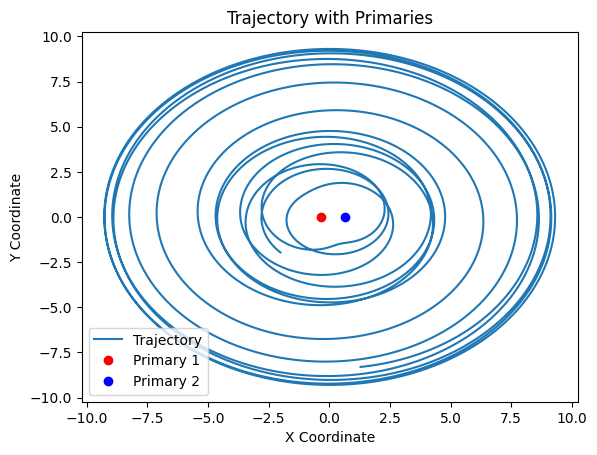

In [24]:
third_trajectory = df.iloc[2]['Trajectory']
print(third_trajectory)
import matplotlib.pyplot as plt

def plot_trajectory_with_primaries(trajectory, mu):
    # Unpack the trajectory points
    x_points, y_points, _,_ = trajectory

    # Create a plot
    fig, ax = plt.subplots()

    # Plot the trajectory
    ax.plot(x_points, y_points, label='Trajectory')

    # Plot the primaries
    primary1 = (-mu, 0)
    primary2 = (1-mu, 0)
    ax.plot(primary1[0], primary1[1], 'ro', label='Primary 1')
    ax.plot(primary2[0], primary2[1], 'bo', label='Primary 2')

    # Set labels and title
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.set_title('Trajectory with Primaries')
    ax.legend()

    # Show the plot
    plt.show()

plot_trajectory_with_primaries(third_trajectory, mu)


In [ ]:
df.to_pickle('dataset1.pkl')


In [30]:
df_loaded = pd.read_pickle('dataset.pkl')
df_loaded

,InitialCondition,Trajectory,Classification
0,"(-2.0, -1.9866220735785953, -1.616479657861119...","([-2.016097474325053, -2.0320595429749924, -2....",Bounded orbit
1,"(-2.0, -2.0, -1.6297465323987625, 1.6297465323...","([-2.01622994916509, -2.032324096945905, -2.04...",Escape orbit
2,"(-2.0, -1.9732441471571907, -1.603229729820175...","([-2.0159651699154844, -2.031795331764623, -2....",Bounded orbit
3,"(-2.0, -1.959866220735786, -1.5899970707875624...","([-2.0158330391542343, -2.0315314697355507, -2...",Escape orbit
4,"(-2.0, -1.9464882943143813, -1.576782007322421...","([-2.0157010852991744, -2.031267963387677, -2....",Bounded orbit
5,"(-2.0, -1.9331103678929766, -1.563584870018259...","([-2.0155693116480613, -2.0310048192997545, -2...",Escape orbit
6,"(-2.0, -1.919732441471572, -1.550405993486368,...","([-2.0154377215383614, -2.0307420441290125, -2...",Escape orbit
7,"(-2.0, -1.8929765886287626, -1.524104381148823...","([-2.0151751054902816, -2.0302176275575907, -2...",Escape orbit
8,"(-2.0, -1.879598662207358, -1.5109823344544344...","([-2.0150440864232686, -2.029955999859339, -2....",Escape orbit
9,"(-2.0, -1.9063545150501673, -1.537245716335670...","([-2.0153063183470334, -2.030479644610705, -2....",Crash into primary 1
